In [1]:
# Import Packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

from sklearn.preprocessing import  MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split, cross_validate, learning_curve, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline

from scipy.stats import uniform, randint
import time
import joblib
import os

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
# Read in pre-processed data from pre-processing step
df = pd.read_csv('../data/pre_processed_churn_df_ready_for_modeling')
df.head()

,Satisfaction Score,Churn Value,Churn Score,CLTV,Number of Referrals,Tenure in Months,Avg Monthly Long Distance Charges,Avg Monthly GB Download,Monthly Charge,Total Charges,Total Refunds,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Age,Number of Dependents,City,Zip Code,Churn Category_Competitor,Churn Category_Dissatisfaction,Churn Category_Other,Churn Category_Price,Churn Reason_Attitude of support person,Churn Reason_Competitor had better devices,Churn Reason_Competitor made better offer,Churn Reason_Competitor offered higher download speeds,Churn Reason_Competitor offered more data,Churn Reason_Deceased,Churn Reason_Don't know,Churn Reason_Extra data charges,Churn Reason_Lack of affordable download/upload speed,Churn Reason_Lack of self-service on Website,Churn Reason_Limited range of services,Churn Reason_Long distance charges,Churn Reason_Moved,Churn Reason_Network reliability,Churn Reason_Poor expertise of online support,Churn Reason_Poor expertise of phone support,Churn Reason_Price too high,Churn Reason_Product dissatisfaction,Churn Reason_Service dissatisfaction,Referred a Friend_Yes,Offer_Offer B,Offer_Offer C,Offer_Offer D,Offer_Offer E,Offer_Unknown/None,Phone Service_Yes,Multiple Lines_Yes,Internet Service_Yes,Internet Type_DSL,Internet Type_Fiber Optic,Online Security_Yes,Online Backup_Yes,Device Protection Plan_Yes,Premium Tech Support_Yes,Streaming TV_Yes,Streaming Movies_Yes,Streaming Music_Yes,Unlimited Data_Yes,Contract_One Year,Contract_Two Year,Paperless Billing_Yes,Payment Method_Credit Card,Payment Method_Mailed Check,Gender_Male,Under 30_Yes,Senior Citizen_Yes,Married_Yes,Dependents_Yes
0,3,1,91,5433,0,1,0.00,8,39.65,39.65,0.00,20,0.00,59.65,78,0,293,90022,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0
1,3,1,69,5302,1,8,48.85,17,80.65,633.30,0.00,0,390.80,1024.10,74,1,293,90063,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,1,1,1
2,2,1,81,3179,0,18,11.33,52,95.45,1752.55,45.61,0,203.94,1910.88,71,3,293,90065,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,1,0,0,0,0,1,1,1,1,0,0,1,0,0,1,0,1,0,1
3,2,1,88,5337,1,25,19.76,12,98.50,2514.50,13.43,0,494.00,2995.07,78,1,25,90303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,1,0,1,1,0,1,0,0,1,0,0,0,0,1,1,1
4,2,1,67,2793,1,37,6.33,14,76.50,2868.15,0.00,0,234.21,3102.36,80,1,30,90602,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,1


In [3]:
#Split data into Features and target variable 'Churn Value'
X = df.drop('Churn Value', axis=1)
y = df['Churn Value']

In [4]:
#Split data into Train & Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7, stratify=y)

In [5]:
# Create scaler: scaler
scaler = MinMaxScaler()

# Create a PCA instance: pca
pca = PCA(n_components=21, random_state=7)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler, pca)

# Fit the pipeline to the training data
pipeline.fit(X_train)

# Transform the training and test data
X_train_pipe = pipeline.transform(X_train)
X_test_pipe = pipeline.transform(X_test)

In [6]:
# Undersample from majority as our classes are imbalanced
from imblearn.under_sampling import RandomUnderSampler

# Define undersampling strategy
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=7)

# Fit and apply the undersampling strategy to the training data
X_train_resampled, y_train_resampled = undersample.fit_resample(X_train_pipe, y_train)

## With our data ready, we'll define our modeling, scoring, and cross validation functions to make our work faster and cleaner as we will be testing several models and comparing scoring metrics of each.

## We will then pick two to three models with the best combination of accuracy, recall, precision, and f1, then tune their hyperparameters to create the best possible model.

In [7]:
#Defining the modeling function

def modeling(alg, alg_name, params={}):
    """
    Fits and trains a given model and computes accuracy scores including accuracy,
        precision, recall, f1 score, full classification report, Matthews correlation coefficient,
        & confusion matrix.

    Parameters:
    - alg: the model function we will be testing.
    - alg_name: name of the model we will be testing.
    - params: parameters if any.

    Returns:
    - model.

    Prints:
    - classification report.
    - scoring metrics.
    - confusion matrix.
    
    """
    global y_pred
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_pipe)

    #Performance evaluation
    def print_scores(alg, y_test, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_test, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_test, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_test, y_pred)
        print("recall: ",rec_score)
        f_score = f1_score(y_test, y_pred, average='weighted')
        print("f1_score: ",f_score)

    report = classification_report(y_test, y_pred)
    print(report)
    
    print_scores(alg, y_test, y_pred)

    # Assuming y_test and y_pred are your true labels and predicted labels respectively
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews correlation coefficient:", mcc)

    # Calculate & plot the confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    return model

In [8]:
# Define a function to perform cross-validation

def cross_validate_model(model, X, y, cv=10):
    """
    Perform cross-validation on our model

    Parameters:
    - model: the fit model to perform cross validation on.
    - X: features.
    - y: target.

    Returns:
    - cross validation scores.
    """
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Print cross-validation scores
    print("Cross-validation scores:", cv_scores)
    print("Mean CV accuracy:", cv_scores.mean())
    print("Standard deviation of CV accuracy:", cv_scores.std())

In [9]:
#Define a function to plot the ROC Curve and AUC

def plot_roc_auc(model, y_test, title='Receiver Operating Characteristic (ROC) Curve'):
    """
    Plots the ROC curve and calculates the AUC score.

    Parameters:
    - y_test: array-like, shape (n_samples,)
        True binary labels in range {0, 1} or {-1, 1}.
    - y_proba: array-like, shape (n_samples,)
        Target scores, can either be probability estimates of the positive class,
        confidence values, or binary decisions.
    - title: string, optional (default='Receiver Operating Characteristic (ROC) Curve')
        Title of the plot.

    Returns:
    - auc_score: float
        Computed Area Under the Curve (AUC) score.
    """
    #global y_proba
    y_proba = model.predict_proba(X_test_pipe)[:, 1] if hasattr(model, "predict_proba") else None
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
        print(f"AUC Score: {auc_score:.4f}\n")
    else:
        print("\n")
        
    # Calculate ROC curve values
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    # Plot ROC curve
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_proba)
    print(f'AUC Score: {auc_score:.4f}')
    
    return auc_score

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1035
           1       0.89      0.94      0.92       374

    accuracy                           0.96      1409
   macro avg       0.94      0.95      0.94      1409
weighted avg       0.96      0.96      0.96      1409

Logistic Regression
accuracy:  0.9552874378992193
precision:  0.8936708860759494
recall:  0.9438502673796791
f1_score:  0.955668820193373
Matthews correlation coefficient: 0.8879863808426363


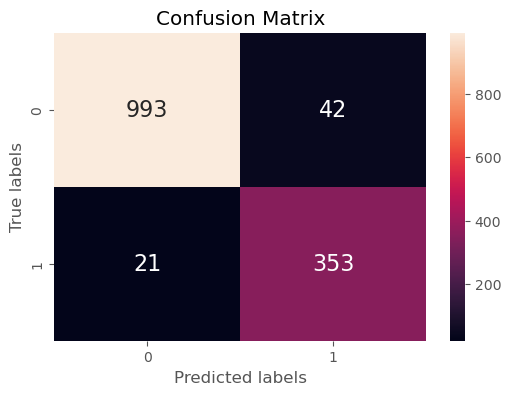

In [10]:
# Running logistic regression model
log_reg_model = modeling(LogisticRegression, 'Logistic Regression', params={'random_state':7})

In [11]:
# Call the cross-validation function
cross_validate_model(log_reg_model, X_train_resampled, y_train_resampled)

Cross-validation scores: [0.97993311 0.95986622 0.95652174 0.95652174 0.95317726 0.94983278
 0.95317726 0.95652174 0.95986622 0.93311037]
Mean CV accuracy: 0.9558528428093644
Standard deviation of CV accuracy: 0.01086827880218857


AUC Score: 0.9892



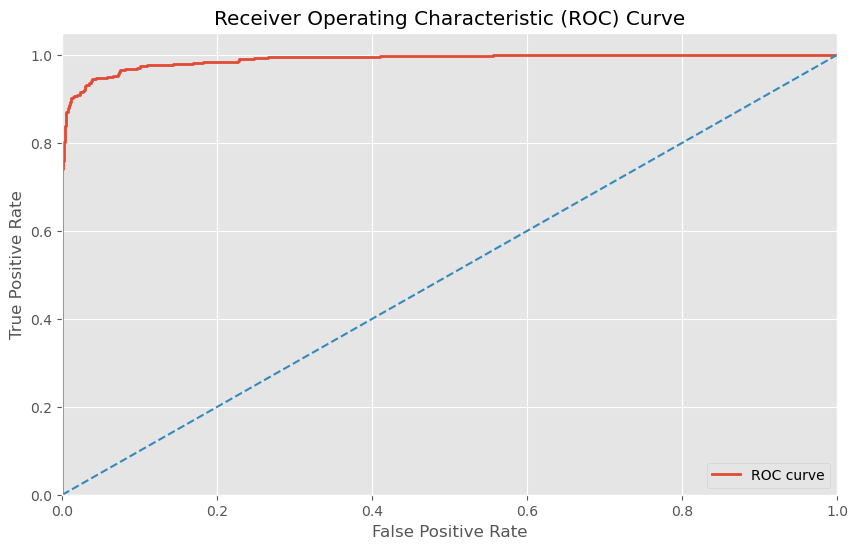

AUC Score: 0.9892


In [12]:
#Call our plot_roc_auc function for the Logistic Regression Model
plot_roc_auc(log_reg_model, y_test);

## The first model we tested and scored was an out of the box logistic regression model and it has done quite well. We could do to increase our precision but our accuracy, recall, and f1 are all very high for the first model we've tested.

## Next we will test a Random Forest Model

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1035
           1       0.83      0.87      0.85       374

    accuracy                           0.92      1409
   macro avg       0.89      0.90      0.90      1409
weighted avg       0.92      0.92      0.92      1409

Random Forest Classifier
accuracy:  0.9176721078779276
precision:  0.8274111675126904
recall:  0.8716577540106952
f1_score:  0.9183424861661676
Matthews correlation coefficient: 0.7929336737863565


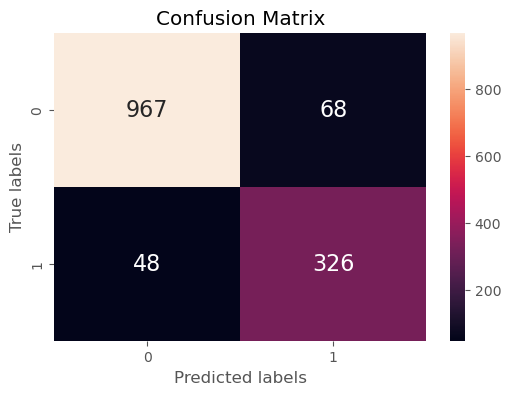

In [13]:
# Random Forest Model

rf_model = modeling(RandomForestClassifier, 'Random Forest Classifier', params={'random_state':7})

In [14]:
# Call the cross-validation function on the Random Forest Model
cross_validate_model(rf_model, X_train_resampled, y_train_resampled)

Cross-validation scores: [0.92976589 0.91638796 0.89297659 0.91304348 0.90635452 0.89966555
 0.89632107 0.93979933 0.92307692 0.87959866]
Mean CV accuracy: 0.9096989966555183
Standard deviation of CV accuracy: 0.01737843619634328


AUC Score: 0.9639



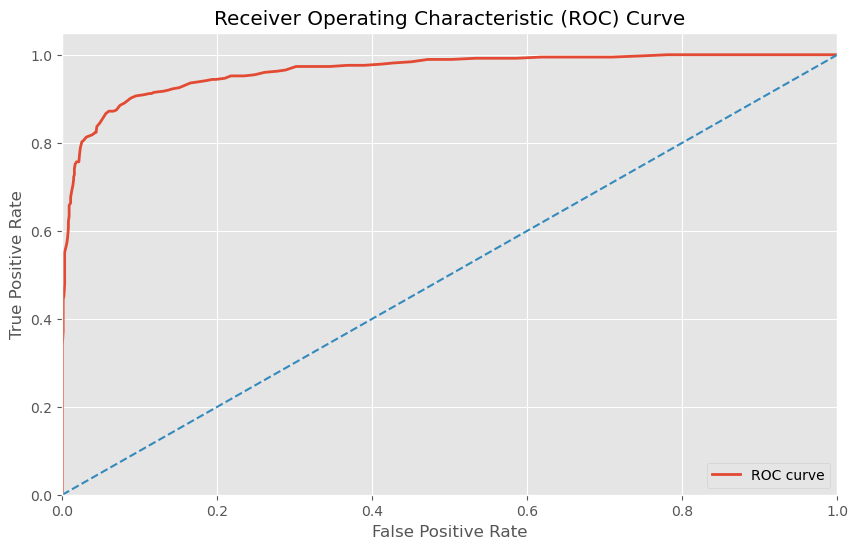

AUC Score: 0.9639


In [15]:
#Call our plot_roc_auc function for the Random Forest Model
plot_roc_auc(rf_model, y_test);

# We could continue in this fashion to test more models, or additionally, we can test as many models as we want and score them all in one block below. We may lose some readability, but we gain much more in efficiency and repeatability. Knowing this, we will continue on by testing all the models and scoring them at once.

Training Logistic Regression
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1035
           1       0.89      0.94      0.92       374

    accuracy                           0.96      1409
   macro avg       0.94      0.95      0.94      1409
weighted avg       0.96      0.96      0.96      1409

Logistic Regression
accuracy:  0.9552874378992193
precision:  0.8936708860759494
recall:  0.9438502673796791
f1_score:  0.955668820193373
Matthews correlation coefficient: 0.8879863808426363


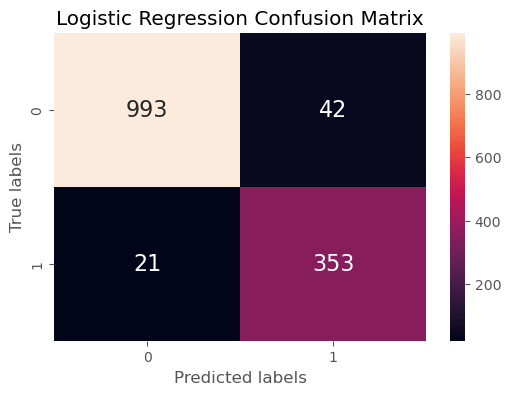

Cross-validation scores: [0.97993311 0.95986622 0.95652174 0.95652174 0.95317726 0.94983278
 0.95317726 0.95652174 0.95986622 0.93311037]
Mean CV accuracy: 0.9558528428093644
Standard deviation of CV accuracy: 0.01086827880218857
AUC Score for Logistic Regression: 0.9892

AUC Score: 0.9892



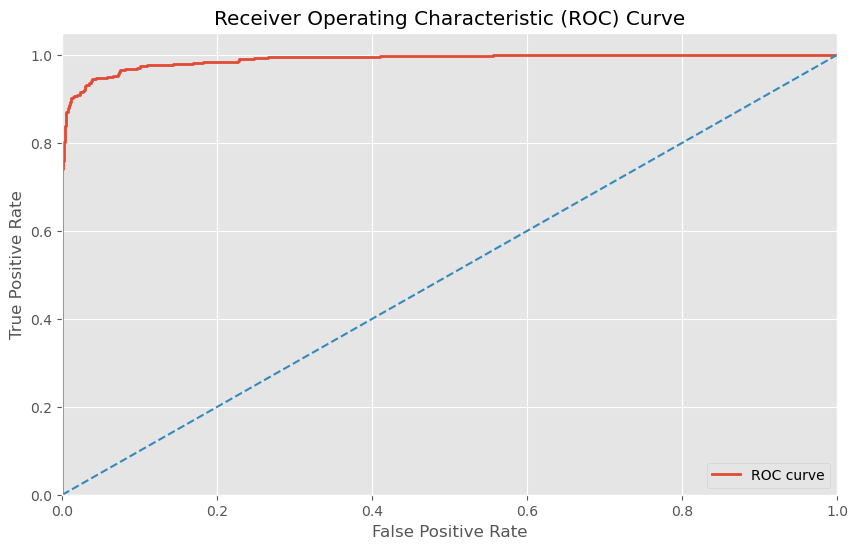

AUC Score: 0.9892
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Decision Tree
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.93      0.85      0.89      1035
           1       0.66      0.82      0.73       374

    accuracy                           0.84      1409
   macro avg       0.79      0.83      0.81      1409
weighted avg       0.86      0.84      0.84      1409

Decision Tree
accuracy:  0.8396025550035486
precision:  0.6601731601731602
recall:  0.8155080213903744
f1_score:  0.8444837348847408
Matthews correlation coefficient: 0.6243936819490686


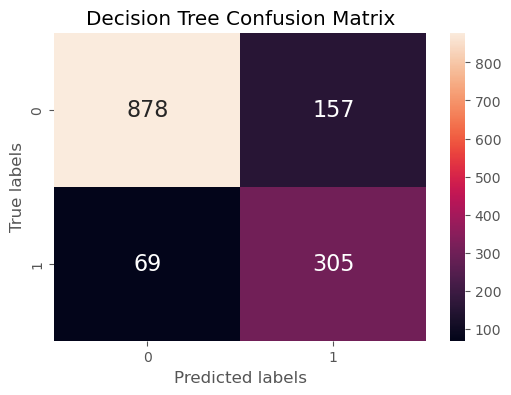

Cross-validation scores: [0.85618729 0.86956522 0.8361204  0.8729097  0.84615385 0.86287625
 0.83277592 0.85618729 0.86622074 0.79598662]
Mean CV accuracy: 0.8494983277591974
Standard deviation of CV accuracy: 0.021982176220943107
AUC Score for Decision Tree: 0.8319

AUC Score: 0.8319



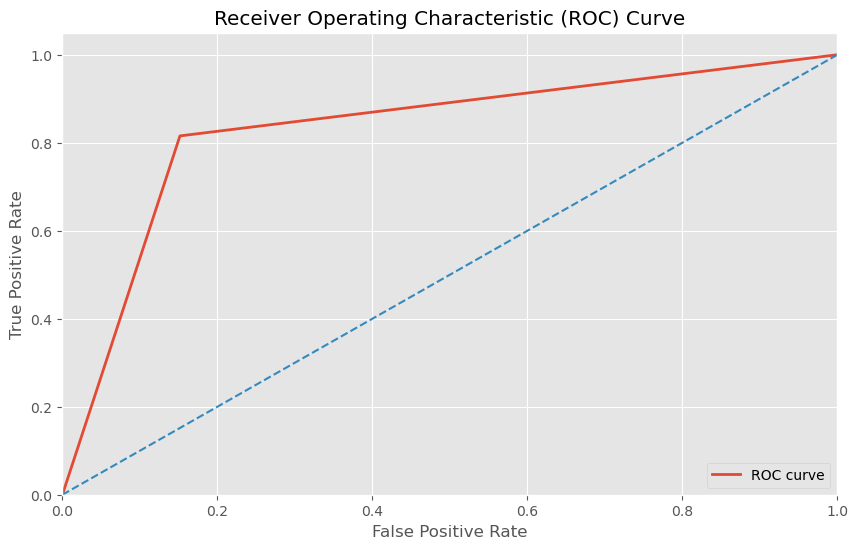

AUC Score: 0.8319
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Random Forest
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94      1035
           1       0.83      0.87      0.85       374

    accuracy                           0.92      1409
   macro avg       0.89      0.90      0.90      1409
weighted avg       0.92      0.92      0.92      1409

Random Forest
accuracy:  0.9176721078779276
precision:  0.8274111675126904
recall:  0.8716577540106952
f1_score:  0.9183424861661676
Matthews correlation coefficient: 0.7929336737863565


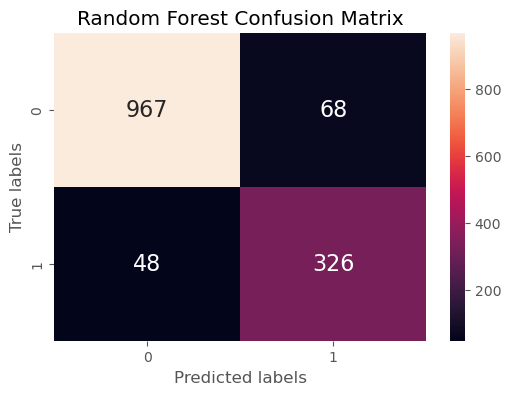

Cross-validation scores: [0.92976589 0.91638796 0.89297659 0.91304348 0.90635452 0.89966555
 0.89632107 0.93979933 0.92307692 0.87959866]
Mean CV accuracy: 0.9096989966555183
Standard deviation of CV accuracy: 0.01737843619634328
AUC Score for Random Forest: 0.9639

AUC Score: 0.9639



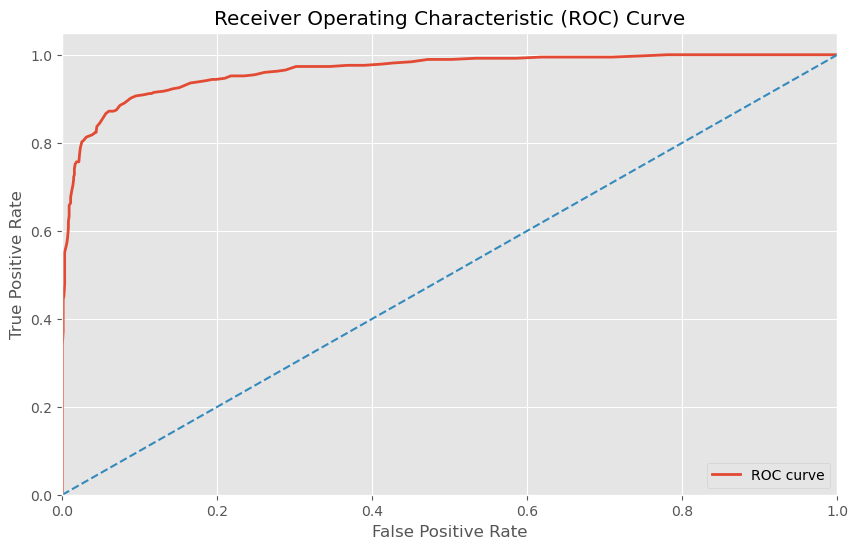

AUC Score: 0.9639
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Gradient Boosting
Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94      1035
           1       0.81      0.89      0.84       374

    accuracy                           0.91      1409
   macro avg       0.88      0.90      0.89      1409
weighted avg       0.92      0.91      0.91      1409

Gradient Boosting
accuracy:  0.9134137686302342
precision:  0.8073170731707318
recall:  0.8850267379679144
f1_score:  0.9146354679847156
Matthews correlation coefficient: 0.7861724108888749


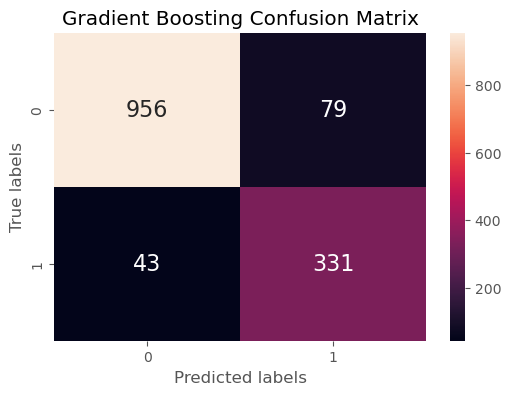

Cross-validation scores: [0.91973244 0.93311037 0.89632107 0.93645485 0.91638796 0.91638796
 0.91638796 0.93979933 0.93311037 0.88294314]
Mean CV accuracy: 0.9190635451505015
Standard deviation of CV accuracy: 0.01723625247722428
AUC Score for Gradient Boosting: 0.9704

AUC Score: 0.9704



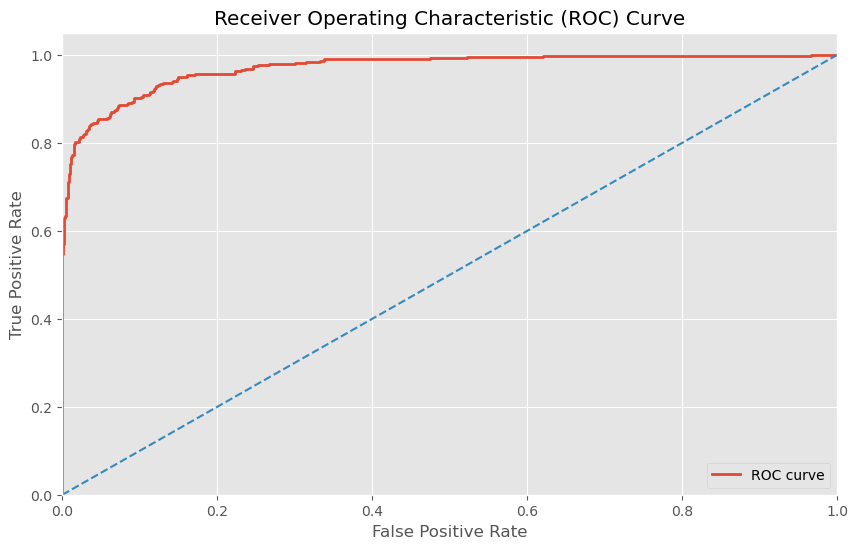

AUC Score: 0.9704
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training XGBoost
Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.96      0.93      0.95      1035
           1       0.83      0.90      0.87       374

    accuracy                           0.93      1409
   macro avg       0.90      0.92      0.91      1409
weighted avg       0.93      0.93      0.93      1409

XGBoost
accuracy:  0.9254790631653655
precision:  0.8304668304668305
recall:  0.9037433155080213
f1_score:  0.926449818591368
Matthews correlation coefficient: 0.8155303680937106


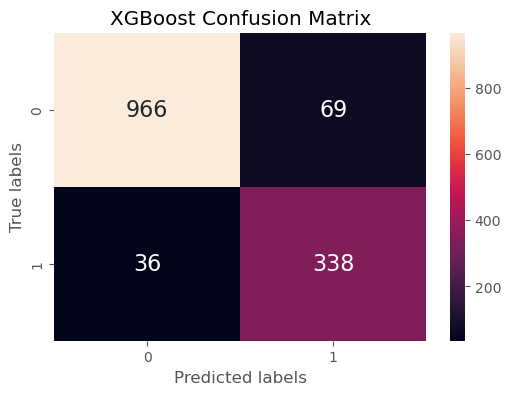

Cross-validation scores: [0.93311037 0.9264214  0.90635452 0.93311037 0.93645485 0.94314381
 0.92976589 0.94648829 0.94314381 0.909699  ]
Mean CV accuracy: 0.9307692307692307
Standard deviation of CV accuracy: 0.01287082368220328
AUC Score for XGBoost: 0.9778

AUC Score: 0.9778



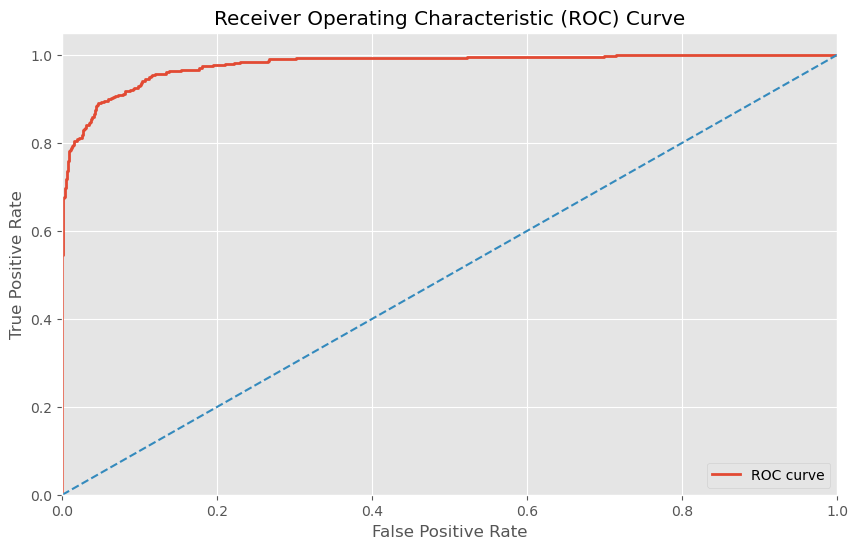

AUC Score: 0.9778
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training CatBoost
Classification Report for CatBoost:
               precision    recall  f1-score   support

           0       0.97      0.94      0.96      1035
           1       0.86      0.91      0.88       374

    accuracy                           0.93      1409
   macro avg       0.91      0.93      0.92      1409
weighted avg       0.94      0.93      0.94      1409

CatBoost
accuracy:  0.9347054648687012
precision:  0.8560606060606061
recall:  0.9064171122994652
f1_score:  0.9352875408724526
Matthews correlation coefficient: 0.836294173018755


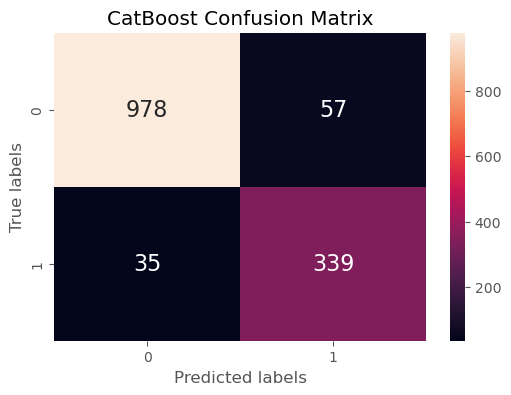

Cross-validation scores: [0.93311037 0.94648829 0.92307692 0.93311037 0.93645485 0.92976589
 0.92976589 0.94983278 0.94983278 0.91638796]
Mean CV accuracy: 0.9347826086956521
Standard deviation of CV accuracy: 0.010602586945917978
AUC Score for CatBoost: 0.9801

AUC Score: 0.9801



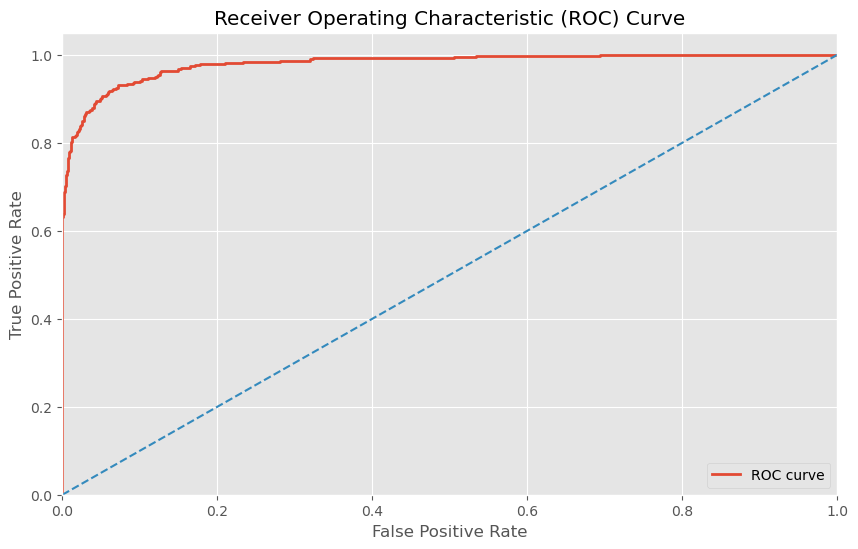

AUC Score: 0.9801
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training SVM
Classification Report for SVM:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97      1035
           1       0.89      0.93      0.91       374

    accuracy                           0.95      1409
   macro avg       0.93      0.94      0.94      1409
weighted avg       0.95      0.95      0.95      1409

SVM
accuracy:  0.9510290986515259
precision:  0.8940568475452196
recall:  0.9251336898395722
f1_score:  0.9512926331693828
Matthews correlation coefficient: 0.8760391196856068


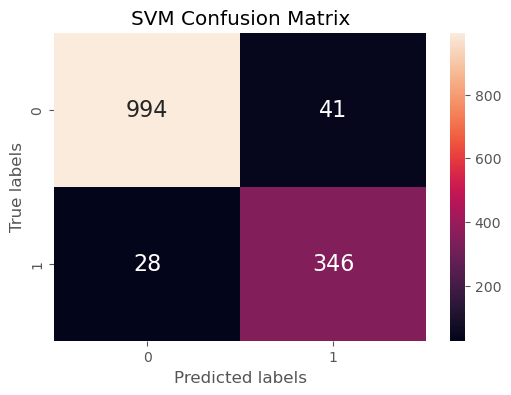

Cross-validation scores: [0.97324415 0.95986622 0.94983278 0.93979933 0.95652174 0.94648829
 0.95317726 0.95317726 0.94648829 0.93311037]
Mean CV accuracy: 0.9511705685618729
Standard deviation of CV accuracy: 0.010491228857095726
AUC Score for SVM: 0.9865

AUC Score: 0.9865



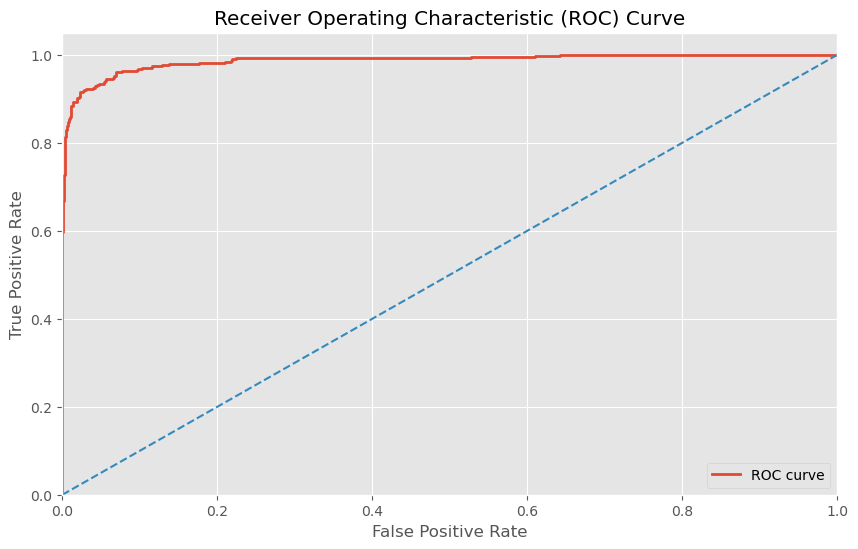

AUC Score: 0.9865
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training KNN
Classification Report for KNN:
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      1035
           1       0.66      0.86      0.75       374

    accuracy                           0.84      1409
   macro avg       0.80      0.85      0.82      1409
weighted avg       0.87      0.84      0.85      1409

KNN
accuracy:  0.8431511710432931
precision:  0.6551724137931034
recall:  0.8636363636363636
f1_score:  0.8491318592480525
Matthews correlation coefficient: 0.6475170223445239


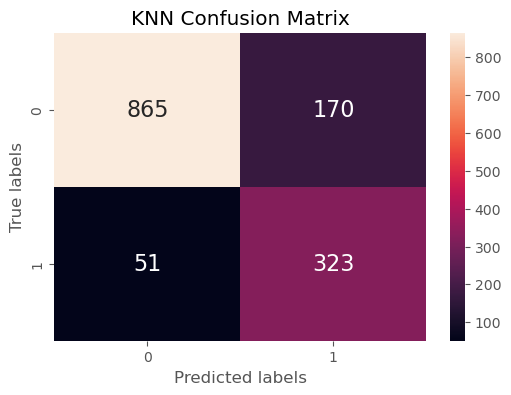

Cross-validation scores: [0.8729097  0.85618729 0.83277592 0.8729097  0.85284281 0.85284281
 0.80936455 0.89632107 0.84615385 0.8361204 ]
Mean CV accuracy: 0.8528428093645486
Standard deviation of CV accuracy: 0.02307449941225462
AUC Score for KNN: 0.9136

AUC Score: 0.9136



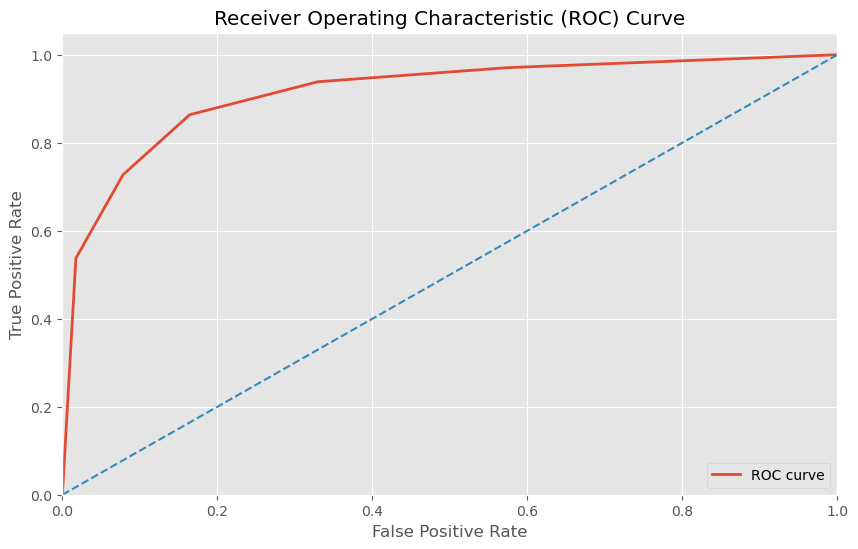

AUC Score: 0.9136
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Naive Bayes
Classification Report for Naive Bayes:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      1035
           1       0.79      0.83      0.81       374

    accuracy                           0.89      1409
   macro avg       0.86      0.87      0.87      1409
weighted avg       0.90      0.89      0.90      1409

Naive Bayes
accuracy:  0.8942512420156139
precision:  0.7862595419847328
recall:  0.8262032085561497
f1_score:  0.8950712212987146
Matthews correlation coefficient: 0.733575207276902


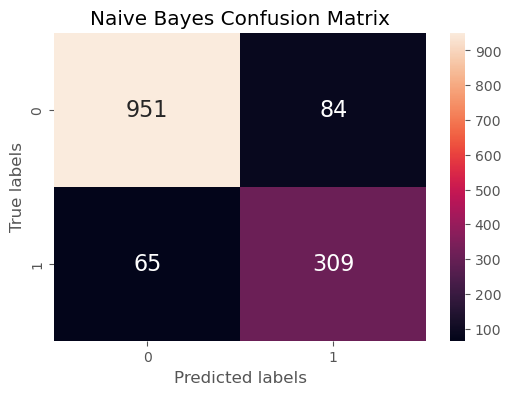

Cross-validation scores: [0.90301003 0.90635452 0.86287625 0.909699   0.89297659 0.90301003
 0.87625418 0.9264214  0.909699   0.83946488]
Mean CV accuracy: 0.8929765886287624
Standard deviation of CV accuracy: 0.02471298087212196
AUC Score for Naive Bayes: 0.9498

AUC Score: 0.9498



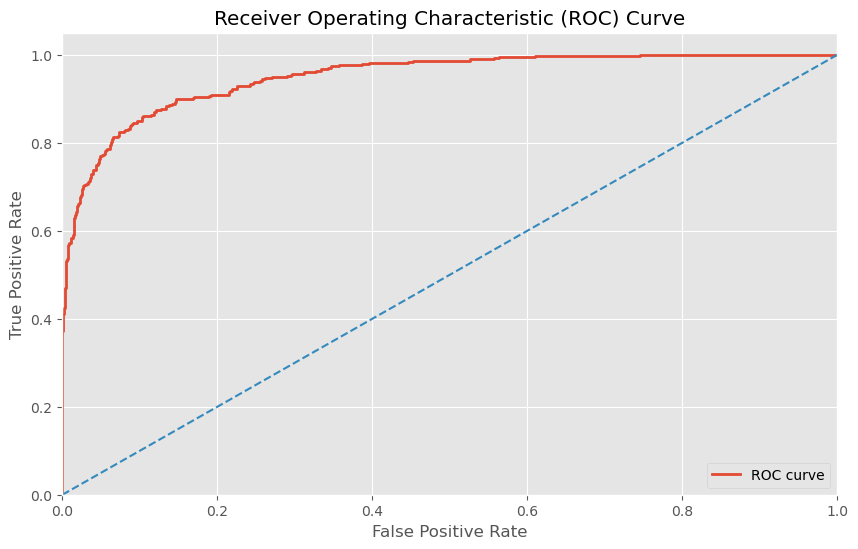

AUC Score: 0.9498
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
Training Neural Network
Classification Report for Neural Network:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      1035
           1       0.90      0.95      0.92       374

    accuracy                           0.96      1409
   macro avg       0.94      0.95      0.95      1409
weighted avg       0.96      0.96      0.96      1409

Neural Network
accuracy:  0.957416607523066
precision:  0.8984771573604061
recall:  0.946524064171123
f1_score:  0.9577633549135349
Matthews correlation coefficient: 0.8932061907529995


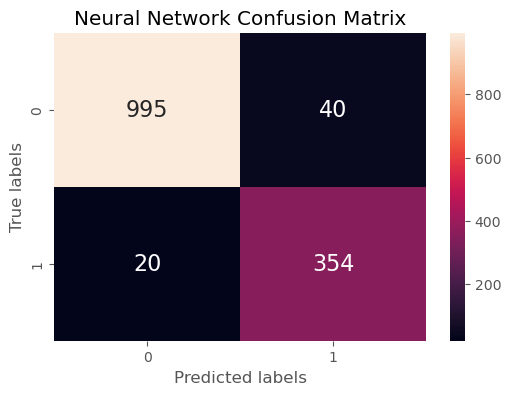

Cross-validation scores: [0.98662207 0.9632107  0.94983278 0.94983278 0.94314381 0.94983278
 0.96989967 0.95652174 0.94983278 0.93979933]
Mean CV accuracy: 0.9558528428093644
Standard deviation of CV accuracy: 0.013277212870420866
AUC Score for Neural Network: 0.9921

AUC Score: 0.9921



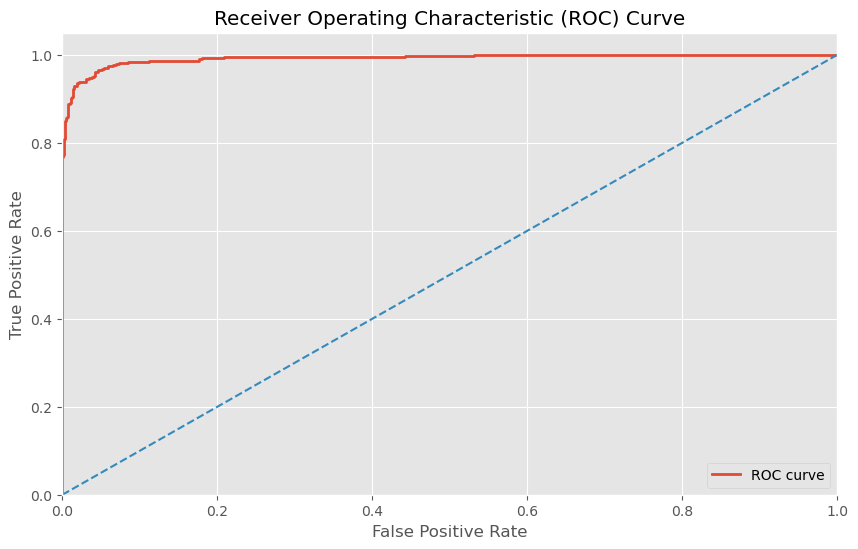

AUC Score: 0.9921
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


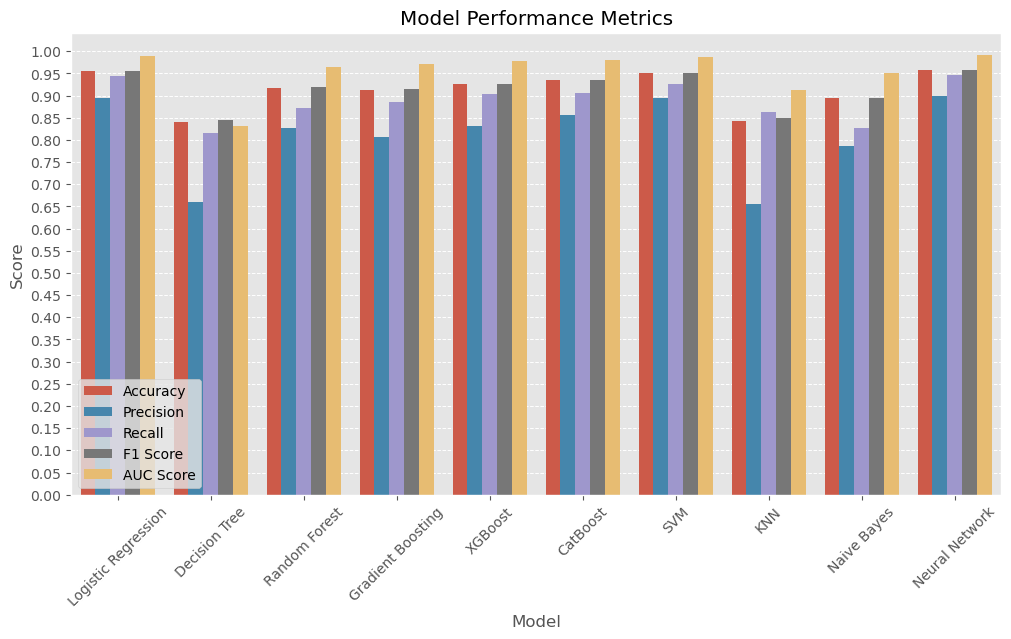

In [16]:
#Import Packages specific to this block (whole black can be taken and re-used for other modeling tasks)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score


# List of 10 models to test
models = [
    ('Logistic Regression', LogisticRegression(random_state=7)),
    ('Decision Tree', DecisionTreeClassifier(random_state=7)),
    ('Random Forest', RandomForestClassifier(random_state=7)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=7)),
    ('XGBoost', XGBClassifier(random_state=7)),
    ('CatBoost', CatBoostClassifier(random_state=7, verbose=0)),
    ('SVM', SVC(probability=True, random_state=7)),
    ('KNN', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(random_state=7, max_iter=500))
]


# DataFrame to store scores for use in our plot of all scoring metrics of all models at the end
scores_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC Score'])


# Loop through models
for name, model in models:
    print(f"Training {name}")
    global y_pred
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_pipe)

    #Performance evaluation
    def print_scores(model, y_test, y_pred):
        print(name)
        acc_score = accuracy_score(y_test, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_test, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_test, y_pred)
        print("recall: ",rec_score)
        f_score = f1_score(y_test, y_pred, average='weighted')
        print("f1_score: ",f_score)


    
    # Print the classificaiton report for the model
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))
    print_scores(model, y_test, y_pred)

    
    # Assuming y_test and y_pred are your true labels and predicted labels respectively
    mcc = matthews_corrcoef(y_test, y_pred)
    print("Matthews correlation coefficient:", mcc)

    
    # Calculate & plot the confusion matrix as a heatmap
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

    
    # Call the cross-validation function on the models
    cross_validate_model(model, X_train_resampled, y_train_resampled)

    # Calculate y probabilities to plot ROC & AUC
    y_proba = model.predict_proba(X_test_pipe)[:, 1] if hasattr(model, "predict_proba") else None
    if y_proba is not None:
        auc_score = roc_auc_score(y_test, y_proba)
        print(f"AUC Score for {name}: {auc_score:.4f}\n")
    else:
        print("\n")

    #Call our plot_roc_auc function for the Model
    plot_roc_auc(model, y_test)
        


     # Calculate scores for scoring plot at the end to review
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    # Append scores to DataFrame
    scores_df = pd.concat([scores_df, pd.DataFrame([{
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC Score': auc
    }])], ignore_index=True)


    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")
    print("_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ")



# Melt the DataFrame we created of all the scores for all models for easier plotting with seaborn
scores_melted = scores_df.melt(id_vars='Model', var_name='Metric', value_name='Score')


# Plot the bar plot of scoring metrics for all models
plt.figure(figsize=(12, 6))
sns.barplot(data=scores_melted, x='Model', y='Score', hue='Metric')
plt.xticks(rotation=45)
plt.title('Model Performance Metrics')
plt.legend(loc="lower left")
plt.grid(axis='y', which='both', linestyle='--', linewidth=0.7) # Add gridlines every 0.05 units on the y-axis
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))
plt.show()

## We've done quite a bit with this block. We've trained and scored 10 models then compared their scoring metrics all at once. Our final plot brings it all together. Conveniently, three models outscored all the others in all metrics making our decision of which models to tune an easy one. The models that did the best in every scoring metric were our logistic regression, SVM, & Neural Network models.

## We'll begin by tuning our logistic regression model first.

Time taken for GridSearchCV: 4.07 seconds
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
Best Cross-Validation Score: 0.9589
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1035
           1       0.87      0.94      0.91       374

    accuracy                           0.95      1409
   macro avg       0.93      0.95      0.94      1409
weighted avg       0.95      0.95      0.95      1409



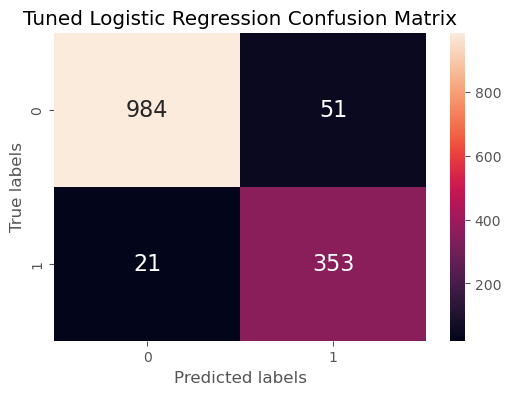

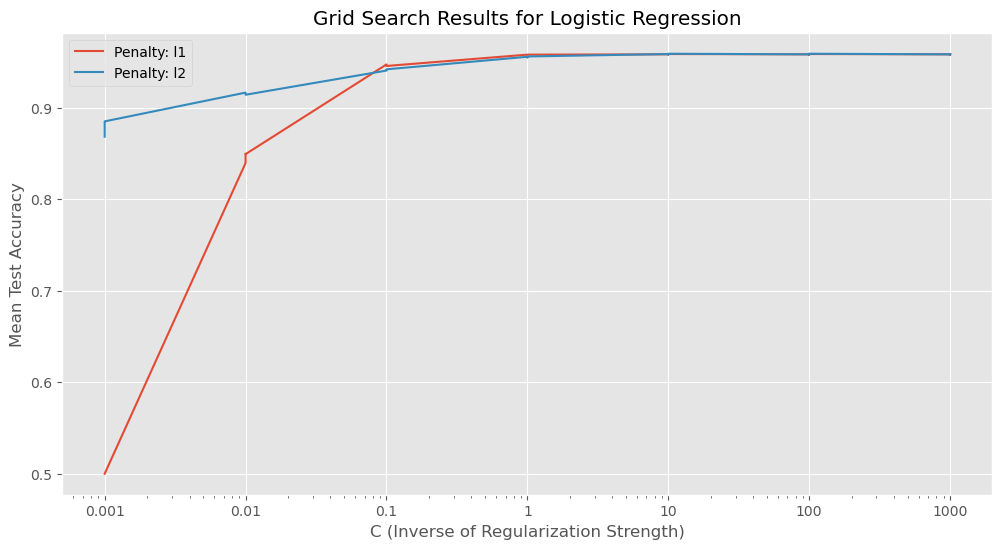

In [17]:
# Logistic Regression Hyperparameter tuning

# Define the model
log_reg = LogisticRegression(multi_class='auto', random_state=7)

# Define the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'tol': [1e-4, 1e-3, 1e-2],
    'solver': ['liblinear', 'saga'],
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy')

# Measure the time taken to run GridSearchCV
start_time = time.time()

# Run GridSearchCV on the training data
grid_search.fit(X_train_resampled, y_train_resampled)

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for GridSearchCV: {elapsed_time:.2f} seconds')

# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pipe)
print(classification_report(y_test, y_pred))

# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.show()

# Extracting results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean test scores for each parameter combination
for penalty in param_grid['penalty']:
    subset = results[results['param_penalty'] == penalty]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=f'Penalty: {penalty}')

plt.xscale('log')
plt.xticks(param_grid['C'], labels=[str(x) for x in param_grid['C']])
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Results for Logistic Regression')
plt.legend()
plt.show()

Time taken for GridSearchCV: 118.49 seconds
Best Parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9595
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1035
           1       0.90      0.94      0.92       374

    accuracy                           0.96      1409
   macro avg       0.94      0.95      0.94      1409
weighted avg       0.96      0.96      0.96      1409



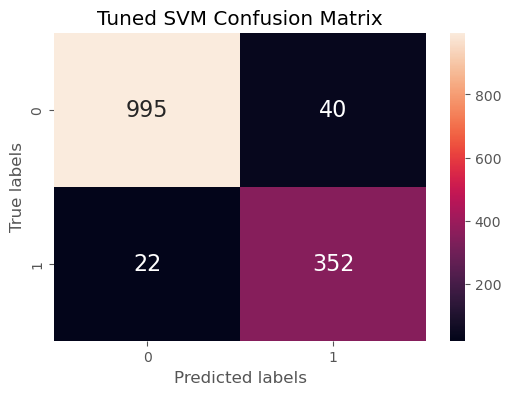

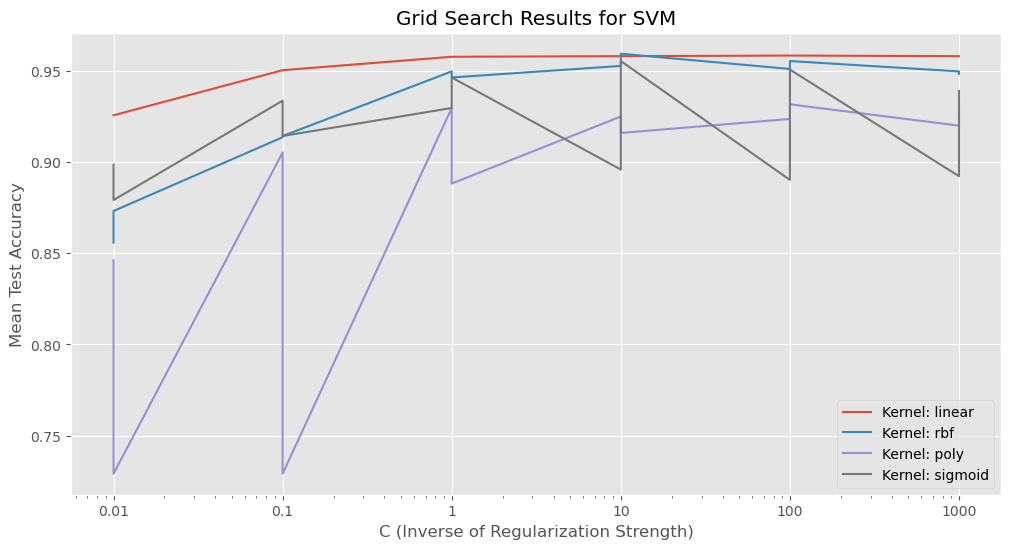

In [18]:
# SVM Hyperparameter tuning

# Define the model
svm = SVC(probability=True, random_state=7)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Measure the time taken to run GridSearchCV
start_time = time.time()

# Run GridSearchCV on the training data
grid_search.fit(X_train_resampled, y_train_resampled)


end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for GridSearchCV: {elapsed_time:.2f} seconds')


# Print the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Cross-Validation Score: {grid_search.best_score_:.4f}')


# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_pipe)
print(classification_report(y_test, y_pred))


# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned SVM Confusion Matrix')
plt.show()

# Extracting results from GridSearchCV
results = pd.DataFrame(grid_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean test scores for each parameter combination
for kernel in param_grid['kernel']:
    subset = results[results['param_kernel'] == kernel]
    plt.plot(subset['param_C'], subset['mean_test_score'], label=f'Kernel: {kernel}')

plt.xscale('log')
plt.xticks(param_grid['C'], labels=[str(x) for x in param_grid['C']])
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Grid Search Results for SVM')
plt.legend()
plt.show()

Time taken for RandomizedSearchCV: 315.13 seconds
Best Parameters: {'activation': 'tanh', 'alpha': 1.0580906938345762, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.9276129377700566, 'solver': 'sgd'}
Best Cross-Validation Score: 0.9582
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1035
           1       0.88      0.94      0.91       374

    accuracy                           0.95      1409
   macro avg       0.93      0.95      0.94      1409
weighted avg       0.95      0.95      0.95      1409



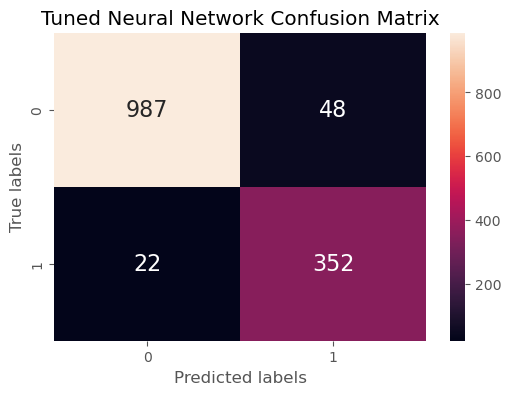

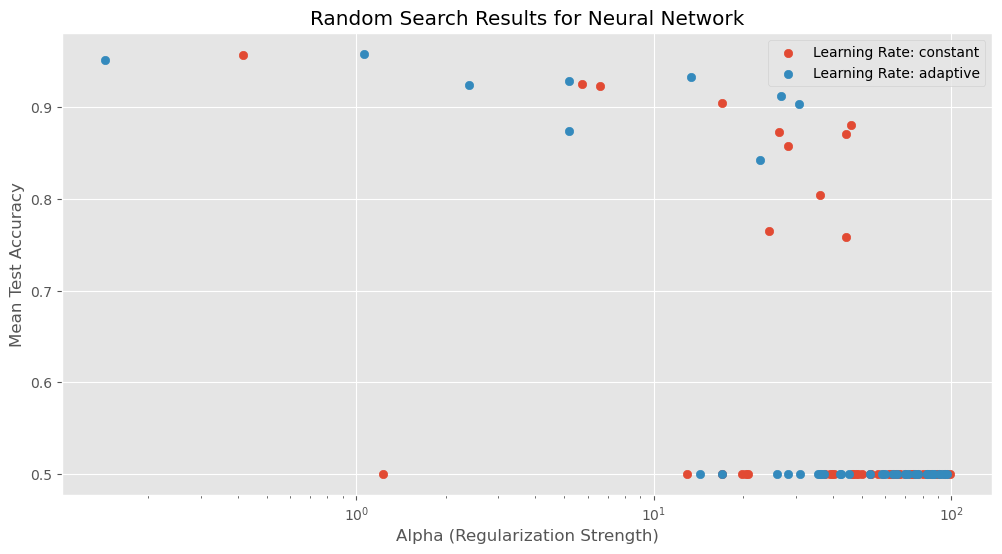

In [19]:
# Neural Network Hyperparameter tuning


# Define the model
nn = MLPClassifier(random_state=7, max_iter=2000)

# Define the parameter distributions
param_distributions = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': uniform(0.0001, 100),  # Uniform distribution between 0.0001 and 10
    'learning_rate': ['constant','adaptive'],
    'learning_rate_init': uniform(0.001, 1.0)  # Uniform distribution between 0.001 and 0.1
}

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(nn, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=7)

# Measure the time taken to run RandomizedSearchCV
start_time = time.time()

# Run RandomizedSearchCV on the training data
random_search.fit(X_train_resampled, y_train_resampled)

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f'Time taken for RandomizedSearchCV: {elapsed_time:.2f} seconds')

# Print the best parameters and the best score
print(f'Best Parameters: {random_search.best_params_}')
print(f'Best Cross-Validation Score: {random_search.best_score_:.4f}')

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test_pipe)
print(classification_report(y_test, y_pred))

# Calculate & plot the confusion matrix as a heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Tuned Neural Network Confusion Matrix')
plt.show()

# Extracting results from RandomizedSearchCV
results = pd.DataFrame(random_search.cv_results_)

# Plotting
plt.figure(figsize=(12, 6))

# Plot mean test scores for each value of alpha, grouped by learning_rate
for learning_rate in param_distributions['learning_rate']:
    subset = results[results['param_learning_rate'] == learning_rate]
    plt.scatter(subset['param_alpha'], subset['mean_test_score'], label=f'Learning Rate: {learning_rate}')

plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Mean Test Accuracy')
plt.title('Random Search Results for Neural Network')
plt.legend()
plt.show()

# Conclusion

### After hyperparameter tuning our top three models, there are only very small differences between the scoring metrics of each model. The Neural Network did slightly worse than the SVM & logistic regression model, and given it's computing cost, we will not proceed further with this model.

### The SVM gives us only a fraction of a percent better accuracy over the much simpler logistic regression model and the other scores are very similar as well.

### The extra computing cost of the the SVM model in this case isn't justified for only the fractional gain in accuracy. In this case, simpler is better. Our best model to predict churn given our data is the tuned logistic regression model which has an accuracy of 95.89%.

Cross-validation scores: [0.98662207 0.96655518 0.9632107  0.95652174 0.95986622 0.94983278
 0.95652174 0.95317726 0.9632107  0.93645485]
Mean CV accuracy: 0.9591973244147157
Standard deviation of CV accuracy: 0.012224526342807393
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      1035
           1       0.87      0.94      0.91       374

    accuracy                           0.95      1409
   macro avg       0.93      0.95      0.94      1409
weighted avg       0.95      0.95      0.95      1409



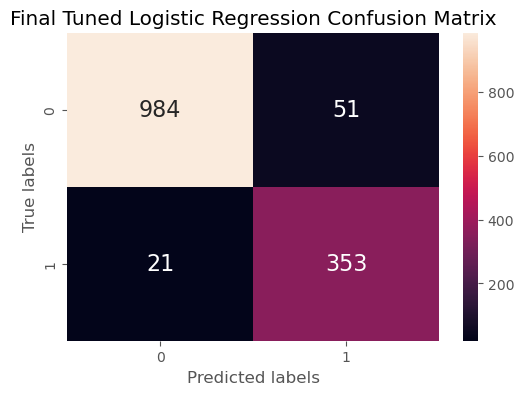

In [20]:
#Instantiate & fit our final model
log_reg_final = LogisticRegression(multi_class='auto', C=10, penalty='l2', solver='saga', tol=0.01, random_state=7)
log_reg_final.fit(X_train_resampled, y_train_resampled)

#Predict & Cross Validate
y_pred = log_reg_final.predict(X_test_pipe)
cross_validate_model(log_reg_final, X_train_resampled, y_train_resampled)
print("-----------------------------------------------------")

#Print Final Classification Report
print(classification_report(y_test, y_pred))

# Calculate & plot final confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 16})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Final Tuned Logistic Regression Confusion Matrix')
plt.show()


## With our final model complete, we will now export the model to predict on future data.

In [21]:
#Exporting the model

# Define the file path
folder_path = '../models'
joblib_file = os.path.join(folder_path, "log_reg_final_model.joblib")

# Export the model
joblib.dump(log_reg_final, joblib_file)

# To load the model later
# loaded_model = joblib.load(joblib_file)
# y_pred_loaded = loaded_model.predict(X_test_pipe)

['../models/log_reg_final_model.joblib']